In [3]:
import zfit
import sys
import os
import xgboost as xgb
import pandas as pd
import uproot3 as uproot
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('/home/oscar/Documents/Thesis/Code/scripts')
import mass_models
import plot_tools

import common_tools
from scipy.interpolate import splrep, BSpline

In [4]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['font.size'] = 25
plt.figure()
plt.close()
plt.rcParams.update({'figure.figsize':[10,8]})
plt.rcParams.update({'font.size':25})

In [5]:
def find_tree_name(uproot_file):
    if 'ROOTDirectory' in str(type(uproot_file)):
        if len(uproot_file.keys())>1:
            print('WARNING! More than one tree, please implement the logic to handle it')
        else:
            return uproot_file.keys()[0].decode()
    else:
        return 'TRUE'

In [6]:
input_data="/home/oscar/Documents/Thesis/RootFiles/Resonant/JPsi_Cut/JPsi_Data_Complete_Final.root"

left_sdb=[4.8,5.12]
right_sdb=[5.422,5.5]

mass_variable = 'massB'

clf_dir = 'Cut'

output_dir = os.path.join('Graph', clf_dir, mass_variable)
os.makedirs(output_dir, exist_ok=True)

In [7]:
minuit  = zfit.minimize.Minuit()

mass_zfit = zfit.Space('massB', [left_sdb[0], right_sdb[1]] )
left_sb  = zfit.Space('massB', left_sdb )
right_sb = zfit.Space('massB', right_sdb )

In [8]:
uproot_file_data = uproot.open(input_data)
# Extract name of the branch to be used
tree_name = find_tree_name(uproot_file_data)
# Create data DataFrame object with all variables
data_df   = uproot_file_data[tree_name].arrays(outputtype=pd.DataFrame)

In [9]:
dataZ_signal = zfit.Data.from_numpy(mass_zfit,
                                np.array(data_df[mass_variable]))
nevents = dataZ_signal.nevents.numpy()
data = dataZ_signal.to_binned(150)
nevents = data.nevents.numpy()
nevents


3930530.0

In [10]:
param1G = zfit.Parameter("mediano1",5.27)
param2G = zfit.Parameter("sigma1",0.053)

param1Gfree = zfit.Parameter("mediano2",5.27)
param2Gfree = zfit.Parameter("sigma2", 0.0307)

param2DCB = zfit.Parameter("sigma",0.0261)
param3DCB = zfit.Parameter("alphal",0.95)
param4DCB = zfit.Parameter("nl",2.1)
param5DCB = zfit.Parameter("alphar",1.09)
param6DCB = zfit.Parameter("nr",4.7)

paramfrac1 = zfit.Parameter("frac1", 0.227)
paramfrac2 = zfit.Parameter("frac2", 0.38)

In [11]:
dcb = zfit.pdf.DoubleCB(param1G, param2DCB, param3DCB, param4DCB, param5DCB, param6DCB, mass_zfit)
gauss = zfit.pdf.Gauss(param1G, param2G, mass_zfit)
gauss_free = zfit.pdf.Gauss(param1Gfree, param2Gfree, mass_zfit)

In [12]:
mu_opts = [np.mean(left_sdb)] + left_sdb
background_model_complete  = mass_models.create_gauss_exp_back(mass_zfit,  mu_opts=mu_opts)

mu_opts = [np.mean([left_sdb[1], right_sdb[0]])] + [left_sdb[1], right_sdb[0]]
#signal_model_complete  = mass_models.create_doubleCB_signal(mass_zfit,  mass_mean= mu_opts)
signal_model_complete  = mass_models.create_doubleCBGauss_signal(mass_zfit,  mass_mean= mu_opts)
#signal_model_complete  = zfit.pdf.SumPDF([gauss, dcb, gauss_free], [paramfrac1,paramfrac2])

In [13]:
Ys = zfit.Parameter('Ysig',nevents/3, 0, nevents*1.1)
Yb = zfit.Parameter('Ybkg',2*(nevents/3), 0, nevents*1.1)

background_model_ext = background_model_complete.create_extended(Yb)
signal_model_ext = signal_model_complete.create_extended(Ys)

complete = zfit.pdf.SumPDF([background_model_ext, signal_model_ext])

In [14]:
free_params = [Ys, Yb, ]
free_params+= list(background_model_complete.get_params())
free_params+= [param for param in list(signal_model_complete.get_params()) if 'mu' in param.name]

In [15]:
n_bins = 150

In [16]:
model_binned = complete.to_binned(data.space)

In [17]:
nll_binned = zfit.loss.BinnedNLL(model_binned, data)

/home/oscar/miniconda3/envs/analysis/lib/python3.8/site-packages/zfit/_loss/binnedloss.py:434: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['extended_in_BinnedNLL'] = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
Extended PDFs ([<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7df1b9716910>]) are given to a normal BinnedNLL.  This won't take the yield into account and simply treat the PDFs as non-extended PDFs. To create an extended NLL, use the `ExtendedBinnedNLL`.
  warn_advanced_feature(


In [18]:
minimum_binned = minuit.minimize(nll_binned, params=free_params)
print(minimum_binned)

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7df1b9716910>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7df1b96c84f0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 1.6e-05 │             18949.85 |  18940.95 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
Ysig                1.30319e+06       False
Ybkg                1.21692e+06       False
frac_mass              0.675526       False
$\mu_B$                 5.07207       False
$\sigma_B$             0.205747       False
$\lambda_B

In [19]:
try:
    minimum_binned.hesse()
except Exception as e:
    print(e)
    minimum = minuit.minimize(nll_binned, params=free_params)
    try:
        minimum.hesse()
    except Exception as e:
        print('Not possible')

/home/oscar/miniconda3/envs/analysis/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")


Ignoring Bins since you passed a binned model!
11760.523833334277
['Ysig = 1.30e+06 $\\pm$ 2.72e+05\nYbkg = 1.22e+06 $\\pm$ 2.54e+05\nfrac_mass = 0.676 $\\pm$ 0.006\n$\\mu_B$ = 5.0721 $\\pm$ 0.0017\n$\\sigma_B$ = 0.2057 $\\pm$ 0.0009\n$\\lambda_B$ = -6.37 $\\pm$ 0.09\n$\\mu$_DCBG = 5.276361 $\\pm$ 2.8e-05']
Using errors from histogram . . . 
bin_model!


{'Ybkg': {'value': 1216919.9465510738, 'hesse': -1},
 'Ysig': {'value': 1303192.1923084946, 'hesse': -1},
 'frac_mass': {'value': 0.6755261749284031, 'hesse': -1},
 '$\\mu_B$': {'value': 5.072066270151187, 'hesse': -1},
 '$\\sigma_B$': {'value': 0.20574737884392746, 'hesse': -1},
 '$\\lambda_B$': {'value': -6.366773116121149, 'hesse': -1},
 'frac_DCBG': {'value': 0.5},
 '$\\mu$_DCBG': {'value': 5.27636093746903, 'hesse': -1},
 '$\\sigma$_DCBG': {'value': 0.029999999329447746},
 '$\\alpha_l$_DCBG': {'value': 1.2000000476837158},
 '$n_l$_DCBG': {'value': 100.0},
 '$\\alpha_r$_DCBG': {'value': 1.2000000476837158},
 '$n_r$_DCBG': {'value': 100.0},
 '$\\sigma_g$_DCBG': {'value': 0.029999999329447746},
 'covariance': [[73726383859.6542,
   68844521317.20671,
   0.3526622877145096,
   0.028012539777359017,
   -0.07944207524597731,
   -11.92927347774668,
   0.0022777033394209257],
  [68844521317.20671,
   64288844147.07255,
   -1.5365884797665796,
   0.971820488987158,
   -0.47659975280874034,

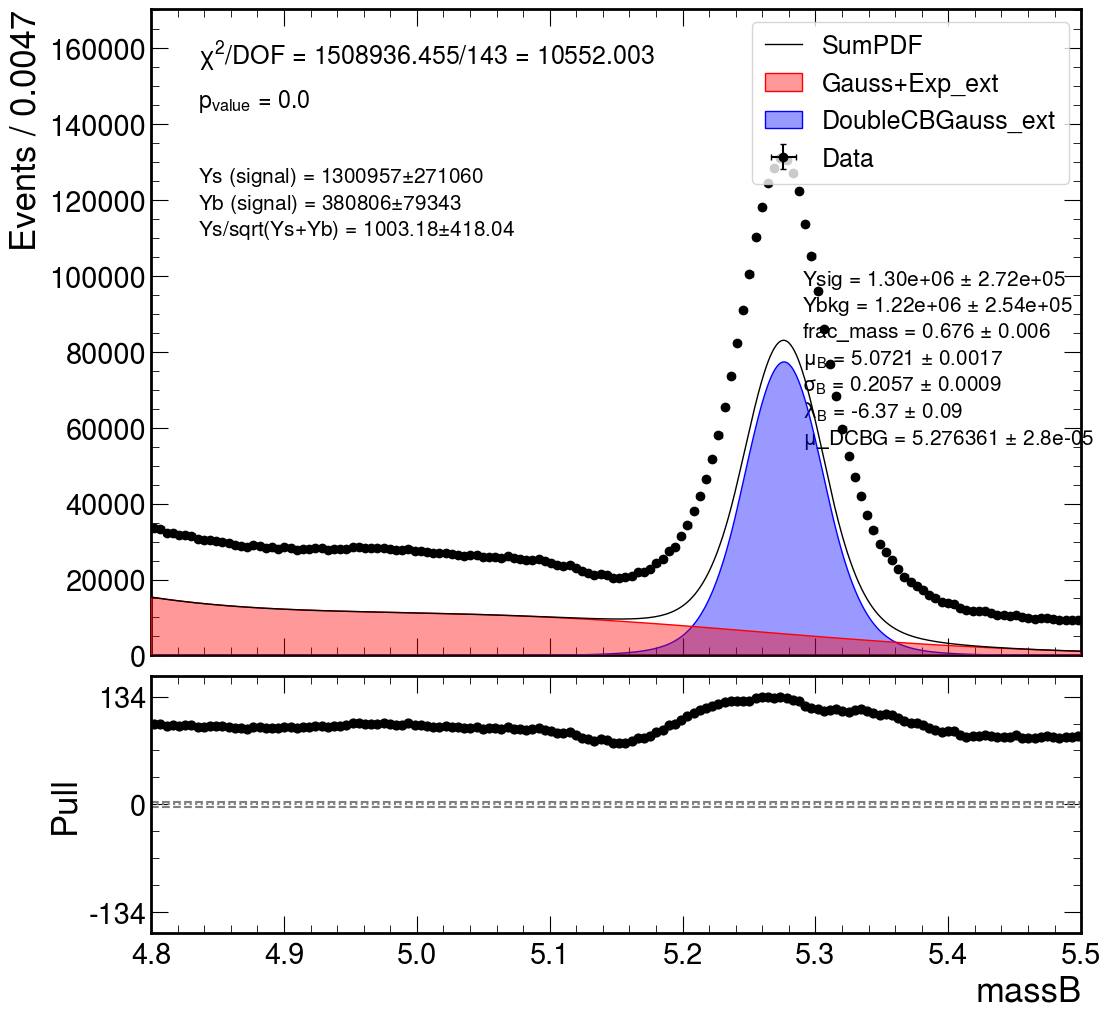

In [20]:
integral_bkg = background_model_complete.integrate([left_sdb[1], right_sdb[0]])
integral_sig = signal_model_complete.integrate([left_sdb[1], right_sdb[0]])

Ys_signal=Ys.value().numpy()*integral_sig.numpy()[0]
Yb_signal=Yb.value().numpy()*integral_bkg.numpy()[0]

Ys_signal_err = np.sqrt(minimum_binned.covariance()[0,0])*integral_sig.numpy()[0]
Yb_signal_err = np.sqrt(minimum_binned.covariance()[1,1])*integral_bkg.numpy()[0]

dFom_dYs = (1/np.sqrt(Ys_signal + Yb_signal)) + (Ys_signal/np.power(np.sqrt(Ys_signal + Yb_signal),3))
dFom_dYb = (Ys_signal/np.power(np.sqrt(Ys_signal + Yb_signal),3))
grad = np.array([dFom_dYs, dFom_dYb])

covariance_yields = common_tools.correlation_to_covariance(minimum_binned.correlation()[0:2,0:2], 
                                                           np.array([Ys_signal_err, Yb_signal_err]))

FOM = Ys_signal/np.sqrt(Ys_signal + Yb_signal)
FOM_err = np.sqrt(grad.dot(covariance_yields).dot(grad.T))


texto = f'Ys (signal) = {round(Ys_signal)}' + '$\pm$' + f'{round(Ys_signal_err)}\n'
texto+= f'Yb (signal) = {round(Yb_signal)}' + '$\pm$' + f'{round(Yb_signal_err)}\n'
texto+= f'Ys/sqrt(Ys+Yb) = {str(round(FOM,2))}' + '$\pm$' + f'{round(FOM_err,2)}'


fig = plt.figure(figsize=[12,12])
_1,_2 = plot_tools.create_axes_for_pulls(fig)
h, chi_ = plot_tools.plot_model(                        
                data_df,
                model_binned, axis=_1, 
                axis_pulls=_2, pulls=True, 
                plot_components=True, bins=10, return_chi2=True,                                                         
                print_params=minimum_binned,
                #remove_string=f'_{q2Bin}',     
                ignore_yield=False,           
                main_kwargs = dict(ls='-', color='black', linewidth=1),
                data_kwargs=dict(marker='o', capsize=2, color='black'),
                params_text_opts = dict(x=0.7, y=0.6, ncol=1, fontsize=15), 
                chi_x=0.05, chi_y=0.9)
_1.text( 0.05, 0.65, texto, transform = _1.transAxes, fontsize=15)
plt.savefig(os.path.join(output_dir, 'BestCut_massB_Fit.pdf'), bbox_inches='tight')

import tools
tools.crate_json_composed(minimum_binned, complete, output_dir, name='Fitted_model.json')